Loading the DPT model)


Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


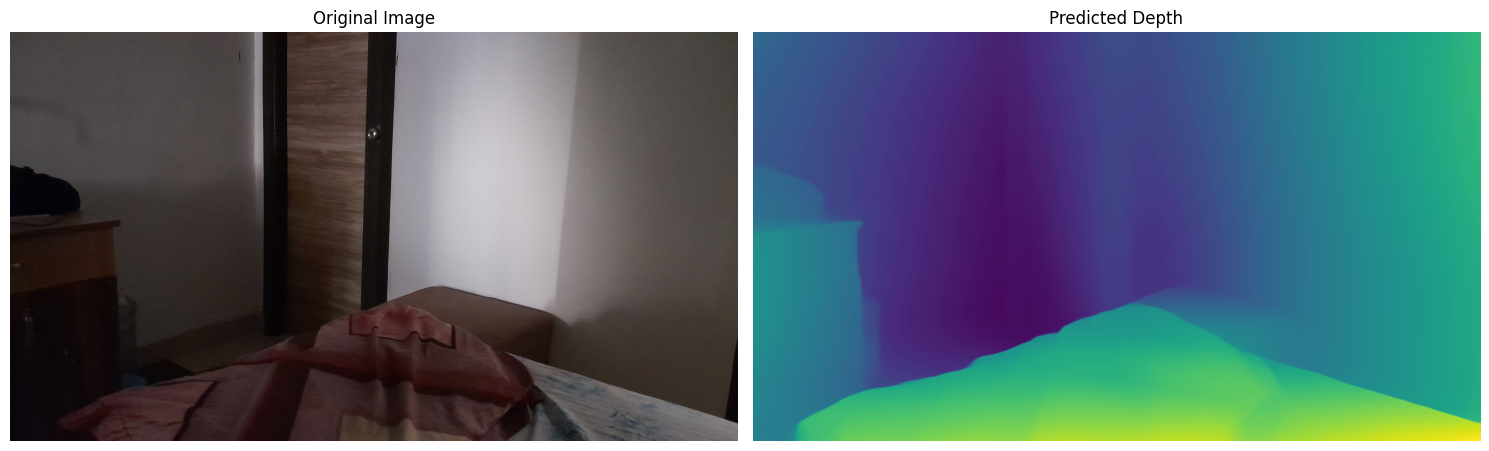

Time taken for resolution: 3.19 seconds


In [3]:
# !pip install -q transformers timm matplotlib

import time
import requests
import cv2
import torch
import numpy as np
from PIL import Image
from transformers import DPTForDepthEstimation, DPTImageProcessor
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import io

print("Loading the DPT model)")

model_name = "Intel/dpt-large"
processor = DPTImageProcessor.from_pretrained(model_name)
model = DPTForDepthEstimation.from_pretrained(model_name)

device = "cuda"
model.to(device)

image_path = "./l.jpg"
frame = cv2.imread(image_path)

start_time = time.time()
rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
image = Image.fromarray(rgb_frame)

# This was tested on 4080*2096 resolution image
inputs = processor(images=image, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth_map = Image.fromarray(formatted)


fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(depth_map, cmap='viridis')
ax[1].set_title("Predicted Depth")
ax[1].axis('off')

plt.tight_layout()
plt.show()

end_time = time.time()
duration = end_time - start_time

# This was tested on 4080*2096 resolution image and took 10.54 seconds on T4 for first run
# On second run it took 3.19 seconds
print(f"Time taken for resolution: {duration:.2f} seconds")